In [117]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer 
from nltk import PorterStemmer
from nltk import LancasterStemmer
import numpy as np

import re
from collections import Counter
def words(text): return re.findall(r'\w+', text.lower())
dictionary = Counter(words(open('/home/retkowski/Data/dicts/dict_all.txt').read()))
 
#stopwords.words('english')

In [130]:
import os # operation system
from collections import namedtuple

NewsCollection = []
News = namedtuple("News",["title","site","topic","text"])

path = "/home/retkowski/Data/data"

count = 0
sites = [site for site in os.listdir(path) if os.path.isdir(os.path.join(path, site)) and not site[0]== "."]
for site in sites:
    sitepath = path +"/"+site
    for categorie in os.listdir(sitepath) :
        if categorie[0] == ".":
            continue
        categoriepath = path+"/"+site+"/"+categorie
        if os.path.exists(categoriepath):
            for file in os.listdir(categoriepath):
                #Strange Empty files ?!
                if file.endswith(".txt") and len(file[:-4]) > 0:
                    with open(categoriepath+"/"+file) as f:
                        newNews = News(title=file[:-4], site=site, topic=categorie, text= f.read())
                        NewsCollection.append(newNews)
                        count += 1
                        f.close()
import random
random.shuffle(NewsCollection)

x_data = [n.text for n in NewsCollection if n.text is not '']
y_data = [n.topic for n in NewsCollection if n.text is not '']

In [131]:
from nltk.tokenize import sent_tokenize, word_tokenize

class Preprocessor():
    
    def __init__(self, stemmer=None, lemmatizer=None, stopwords=None):
        self.stemmer = stemmer
        self.lemmatizer = lemmatizer
        self.stopwords = stopwords
            
    def _tokenize(self, string):
        return word_tokenize(string)
    
    def _filter_for_words(self, tokens):
        return [w for w in tokens if w.isalpha()]
    
    def _lowercase_words(self, tokens):
        return [w.lower() for w in tokens]
    
    def _remove_stopwords(self, tokens):
        return [w for w in tokens if w not in self.stopwords]
    
    def _stem(self, tokens):
        return [self.stemmer.stem(t) for t in tokens]

    def _lemmatize(self, tokens):
        return [self.lemmatizer.lemmatize(t) for t in tokens]
    
    def _process(self, string):
        tokens = self._tokenize(string)
        tokens = self._filter_for_words(tokens)
        tokens = self._lowercase_words(tokens)
        if self.stopwords is not None:
            tokens = self._remove_stopwords(tokens)
        if self.stemmer is not None:
            tokens = self._stem(tokens)
        elif self.lemmatizer is not None:
            tokens = self._lemmatize(tokens)
        return tokens
    
    def get_preprocessed_text(self, string):
        return ' '.join(self._process(string))
    
    def get_preprocessed_tokens(self, string):
        return self._process(string)

In [132]:
preprocessor = Preprocessor( stopwords = stopwords.words('english'), stemmer = SnowballStemmer("english") )
preprocessor.get_preprocessed_text("This is a dumb test. He runs quickly.")

'dumb test run quick'

In [133]:
preprocessor.get_preprocessed_tokens("This is a dumb test. He runs quickly.")
preprocessor.get_preprocessed_tokens("The cycle of cycling")

['cycl', 'cycl']

In [134]:
from sklearn.base import BaseEstimator
from nltk import pos_tag
import nltk
import math

# mehr Wortarten…

class LinguisticVectorizer(BaseEstimator):

    def get_feature_names(self):
        return np.array(
            ['text_length',
             'number_of_paragraphs',
             'average_sent_length',
             'average_word_length',
             'number_of_nouns',
             'number_of_adjectives',
             'number_of_verbs',
             'type_token_relation',
             'concentration_index',
             'hapaxes_index',
             'action_index',
             'number_of_spelling_mistakes',
             'number_of_question_marks',
             'number_of_exclamations',
             'number_of_percentages',
             'number_of_currency_symbols',
             'number_of_paragraph_symbols',
             'content_fraction',
             'number_of_cappsed_words']
        )

    def fit(self, documents, y=None):
        return self
    
    def __filter(self, string):
        return [w for w in word_tokenize(string) if w.isalpha()]
    
    def _get_text_length(self, string):
        tokens = self.__filter(string)
        return len(tokens)
    
    def _get_number_of_paragraphs(self, string):
        return round(string.count('\n') / 2)
    
    def _get_average_sent_length(self, string):
        tokens = self.__filter(string)
        if len(sent_tokenize(string)) is 0:
            return len(tokens)
        return len(tokens) / len(sent_tokenize(string))
    
    def _get_average_word_length(self, string):
        tokens = self.__filter(string)
        word_length_list = []
        for word in tokens:
            word_length_list.append(len(word))
        return np.average(word_length_list)

    def _get_number_of_nouns(self, string):
        nouns = [a[0] for a in pos_tag(self.__filter(string)) if a[1] in ['NN', 'NNS', 'NNP', 'NNPS']]
        return len(nouns) / self._get_text_length(string)
    
    def _get_number_of_adjectives(self, string):
        adjectives = [a[0] for a in pos_tag(self.__filter(string)) if a[1] in ['JJ', 'JJR', 'JJS']]
        return len(adjectives) / self._get_text_length(string)
   
    def _get_number_of_verbs(self, string):
        verbs = [a[0] for a in pos_tag(self.__filter(string)) if a[1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']]
        return len(verbs) / self._get_text_length(string)
    
    def _get_ttr(self, string):
        tokens = self.__filter(string)
        if len(tokens) is 0:
            return 0
        return len(set(tokens)) / len(tokens)

    def _get_aq(self, string):
        adjectives = self._get_number_of_adjectives(string)
        verbs = self._get_number_of_verbs(string)
        if adjectives is 0:
            return verbs
        return verbs / adjectives

    def _get_naq(self, string):
        adjectives = self._get_number_of_adjectives(string)
        verbs = self._get_number_of_verbs(string)
        if adjectives is 0 and verbs is 0:
            return 0
        return verbs / (adjectives + verbs)

    def _get_hl(self, string):
        words = self.__filter(string)
        fdist = nltk.FreqDist(words)
        hapaxes = fdist.hapaxes()
        if len(words) is 0:
            return len(hapaxes)
        return len(hapaxes) / len(words)

    def _get_koi(self, string, n):
        words = self.__filter(string)
        fdist = nltk.FreqDist(words)
        sum = 0
        for word in fdist.most_common(n):
            sum += word[1]
        if len(words) is 0:
            return sum
        return sum / len(words)

    def _get_nkoi(self, string, n, m):
        words = self.__filter(string)
        h = math.floor(len(words) / m)
        if h is 0:
            return self._get_koi(string, 15)
        sum = 0
        for i in range(h):
            sum += self._get_nkoi_i(words[i*m:(i+1)*m],n)
        return (sum/h)

    def _get_nkoi_i(self, words, n):
        fdist = nltk.FreqDist(words)
        sum = 0
        for word in fdist.most_common(n):
            sum += word[1]
        if len(words) is 0:
            return sum
        return sum / len(words)
    
    def _get_number_of_spelling_mistakes(self, string):
        text_vocub = set(w.lower() for w in word_tokenize(string) if w.isalpha())
        text_dict  = set(w.lower() for w in dictionary)
        return len(text_vocub - text_dict) / self._get_text_length(string)
    
    def _get_number_of_currency_symbols(self, string):
        currencies = ["£","€","$","¥","¢","₩"]
        sum = 0
        for currency in currencies:
            sum += self._get_number_of_symbol(string, currency)
        return sum / self._get_text_length(string)
    
    def _get_number_of_symbol(self, string, symbol):
        return string.count(symbol) / self._get_text_length(string)
    
    def _get_content_fraction(self, string):
        tokens = self.__filter(string)
        content = [w for w in tokens if w.lower() not in stopwords.words('english')]
        if len(tokens) is 0:
            return 0
        return len(content) / len(tokens)
    
    def _get_number_of_cappsed_words(self, string):
        tokens = self.__filter(string)
        return np.sum([t.isupper() for t in tokens if len(t) > 2]) / self._get_text_length(string)

    def transform(self, documents):
        text_length = [self._get_text_length(d) for d in documents]
        number_of_paragraphs = [self._get_number_of_paragraphs(d) for d in documents]
        average_length_of_sent = [self._get_average_sent_length(d) for d in documents]
        average_word_length = [self._get_average_word_length(d) for d in documents]
        number_of_nouns = [self._get_number_of_nouns(d) for d in documents]
        number_of_adjectives = [self._get_number_of_adjectives(d) for d in documents]
        number_of_verbs = [self._get_number_of_verbs(d) for d in documents]
        type_token_relation = [self._get_ttr(d) for d in documents]
        concentration_index = [self._get_nkoi(d,10,150) for d in documents]
        hapaxes_index = [self._get_hl(d) for d in documents]
        action_index = [self._get_naq(d) for d in documents]
        number_of_spelling_mistakes = [self._get_number_of_spelling_mistakes(d) for d in documents]
        number_of_question_marks = [self._get_number_of_symbol(d, "?") for d in documents]
        number_of_exclamations = [self._get_number_of_symbol(d, "!") for d in documents]
        number_of_percentages = [self._get_number_of_symbol(d, "%") for d in documents]
        number_of_currency_symbols = [self._get_number_of_currency_symbols(d) for d in documents]
        number_of_paragraph_symbols = [self._get_number_of_symbol(d, "§") for d in documents]
        content_fraction = [self._get_content_fraction(d) for d in documents]
        number_of_cappsed_words = [self._get_number_of_cappsed_words(d) for d in documents]

        result = np.array(
            [text_length,
             number_of_paragraphs,
             average_length_of_sent,
             average_word_length,
             number_of_nouns,
             number_of_adjectives,
             number_of_verbs,
             type_token_relation,
             concentration_index,
             hapaxes_index,
             action_index,
             number_of_spelling_mistakes,
             number_of_question_marks,
             number_of_exclamations,
             number_of_percentages,
             number_of_currency_symbols,
             number_of_paragraph_symbols,
             content_fraction,
             number_of_cappsed_words]
        ).T

        return result


In [135]:
ling = LinguisticVectorizer()
texts = ["This is a TEST. %%%%%%%%%%%%",
         "This IS a SECOND test with only one sentence!",
         "This is a THIRD TEST. With TWO sentences and tests?"]
ling.fit(texts)
x_ling = ling.transform(texts)

print(x_ling)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True)
scaled = scaler.fit_transform(x_ling)
print(scaled)

from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
mmscaled = mmscaler.fit_transform(scaled)
print(mmscaled)

[[  4.     0.     2.     2.75   0.25   0.     0.25   1.     1.     1.     1.
    0.     0.     0.     3.     0.     0.     0.25   0.25]
 [  9.     0.     9.     4.     0.22   0.11   0.11   1.     1.     1.     0.5
    0.     0.     0.11   0.     0.     0.     0.44   0.11]
 [ 10.     0.     5.     4.     0.4    0.1    0.1    1.     1.     1.     0.5
    0.     0.1    0.     0.     0.     0.     0.5    0.3 ]]
[[-1.4   0.   -1.16 -1.41 -0.52 -1.41  1.41  0.    0.    0.    1.41  0.
  -0.71 -0.71  1.41  0.    0.   -1.38  0.37]
 [ 0.51  0.    1.28  0.71 -0.88  0.82 -0.62  0.    0.    0.   -0.71  0.
  -0.71  1.41 -0.71  0.    0.    0.43 -1.37]
 [ 0.89  0.   -0.12  0.71  1.4   0.59 -0.79  0.    0.    0.   -0.71  0.
   1.41 -0.71 -0.71  0.    0.    0.95  1.  ]]
[[ 0.    0.    0.    0.    0.16  0.    1.    0.    0.    0.    1.    0.    0.
   0.    1.    0.    0.    0.    0.74]
 [ 0.83  0.    1.    1.    0.    1.    0.07  0.    0.    0.    0.    0.    0.
   1.    0.    0.    0.    0.78  0.  ]
 [ 

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=1, ngram_range=(1,3))
x = vectorizer.fit_transform([preprocessor.get_preprocessed_text(t) for t in texts])
print("||".join(vectorizer.get_feature_names()))
x.toarray()

one||one sentenc||second||second test||second test one||sentenc||sentenc test||test||test one||test one sentenc||test two||test two sentenc||third||third test||third test two||two||two sentenc||two sentenc test


array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int64)

In [18]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(x)
x_tf = tf_transformer.transform(x)
print(x_tf.toarray())

[[ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.33333333  0.33333333  0.33333333  0.33333333  0.33333333  0.33333333
   0.          0.33333333  0.33333333  0.33333333  0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.26726124
   0.26726124  0.53452248  0.          0.          0.26726124  0.26726124
   0.26726124  0.26726124  0.26726124  0.26726124  0.26726124  0.26726124]]


In [19]:
tfidf_transformer = TfidfTransformer()
x_tf_idf = tfidf_transformer.fit_transform(x)
print(x_tf_idf.toarray()) 

[[ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.35517252  0.35517252  0.35517252  0.35517252  0.35517252  0.27011786
   0.          0.20977061  0.35517252  0.35517252  0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.22958167
   0.30187231  0.3565813   0.          0.          0.30187231  0.30187231
   0.30187231  0.30187231  0.30187231  0.30187231  0.30187231  0.30187231]]


In [1]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import decomposition
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer


# max_df = 0.75 for corpus-specific stopwords
cv = CountVectorizer(max_df=0.75, ngram_range=(1,1), max_features=1000, preprocessor=preprocessor.get_preprocessed_text)
tt = TfidfTransformer()
lv = LinguisticVectorizer()
clf = MultinomialNB() # GaussianNB
clf = LogisticRegression()

fu = FeatureUnion([
    ('ngram_tf_idf', Pipeline([
      ('counts', cv),
      ('tf_idf', tt),
      ('scaler', StandardScaler(with_mean=False)),
      ('mascaler', MaxAbsScaler())
    ])),
    ('lv', Pipeline([
      ('linguistic', lv),
      ('scaler', StandardScaler(with_mean=False)),
      ('mascaler', MaxAbsScaler())
    ]))
])

pipeline = Pipeline([
  ('features', fu),
  #('scaler', StandardScaler(with_mean=False)), # without: 0.20, after 0.67
  #('mascaler', MaxAbsScaler()), # after: 0.69
  ('classifier', clf)
])

#print(np.isnan(x_data).any())

NameError: name 'preprocessor' is not defined

In [115]:
#print(x_data[13])
#print(x_data[8])
#print(y_data[13])
#print(NewsCollection[8])
#News(title='As a prison doctor I’ve seen the crisis in jails – half the inmates shouldn’t be there', site='guardian', topic='opinion', text='')
pipeline.fit(x_data[:175], y_data[:175])

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('ngram_tf_idf', Pipeline(steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_featu...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [116]:
print(len(cv.get_feature_names()))
#print(cv.get_feature_names())
print(pipeline.score(x_data[175:], y_data[175:]))

1000
0.602941176471


             precision    recall  f1-score   support

   business       0.50      0.60      0.55        10
    economy       0.50      0.17      0.25         6
  lifestyle       0.67      0.55      0.60        11
    opinion       1.00      0.12      0.22         8
   politics       0.73      0.80      0.76        10
    science       0.67      0.67      0.67         6
      sport       0.67      0.86      0.75         7
       tech       0.50      0.90      0.64        10

avg / total       0.65      0.60      0.57        68

accuracy: 0.603
Confusion matrix, without normalization
[[6 0 0 0 0 1 0 0]
 [0 9 0 0 0 0 0 1]
 [0 1 4 0 0 0 1 0]
 [1 0 0 8 0 0 0 1]
 [1 3 0 2 1 1 0 0]
 [0 3 2 0 0 6 0 0]
 [1 0 0 0 0 0 1 4]
 [0 2 0 1 0 1 0 6]]


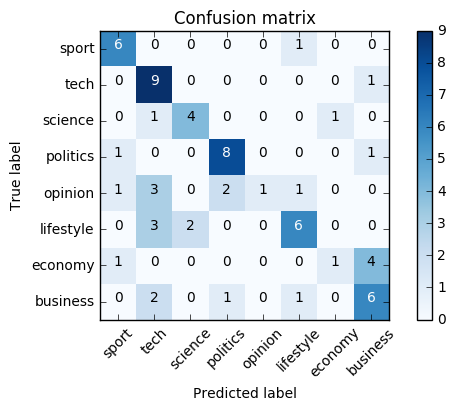

precision: tp / (tp + fp) –– positive predictive value (PPV)
recall: tp / (tp + fn) –– true positive rate or sensitivity
f1-score: 2 * (precision * recall) / (precision + recall)
accuracy: (tp + tn) / (tp + tn + fp + fn)
support: number of samples


In [106]:
from sklearn import metrics
import itertools
import numpy as np
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def print_report(pipe):
    y_test = y_data[175:]
    y_pred = pipe.predict(x_data[175:])
    #print(y_test)
    #print(y_pred)
    report = metrics.classification_report(y_test, y_pred)
    print(report)
    print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))
    np.set_printoptions(precision=2)
    classes = ["sport", "tech", "science", "politics", "opinion", "lifestyle", "economy", "business"]
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred, classes)
    plt.figure()
    plot_confusion_matrix(confusion_matrix,classes)
    plt.show()

print_report(pipeline)
print("precision: tp / (tp + fp) –– positive predictive value (PPV)")
print("recall: tp / (tp + fn) –– true positive rate or sensitivity")
print("f1-score: 2 * (precision * recall) / (precision + recall)")
print("accuracy: (tp + tn) / (tp + tn + fp + fn)")
print("support: number of samples")

In [98]:
import eli5

features_names = cv.get_feature_names()
features_names.extend(lv.get_feature_names())

#print(pipeline.transform([x_data[175]]))

#print(features_names)
eli5.show_weights(clf, top=50, feature_names=features_names)

In [97]:
eli5.show_prediction(clf, x_data[177], feature_names=features_names, vec=fu, top=10, horizontal_layout=True, force_weights=False)

In [425]:
from nltk.corpus import movie_reviews as mr
documents = [(movie_reviews.raw(fileid), category)
            for category in movie_reviews.categories()
            for fileid in movie_reviews.fileids(category)]
numtrain = int(len(documents) * 90 / 100)

random.shuffle(documents)

train_set = documents[:400]
test_set = documents[400:800]

In [426]:
x_movies = [i[0] for i in train_set]
y_movies = [i[1] for i in train_set]

x_movies_test = [i[0] for i in test_set]
y_movies_test = [i[1] for i in test_set]

In [427]:
pipeline.fit(x_movies, y_movies)
print(pipeline.score(x_movies_test, y_movies_test))

0.785


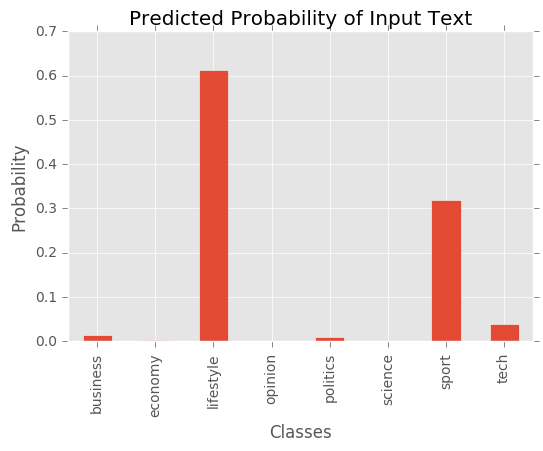

In [472]:
classes = pipeline.classes_
probability = pipeline.predict_proba(["This movie is good."])
print_probabilites(probability, classes) 

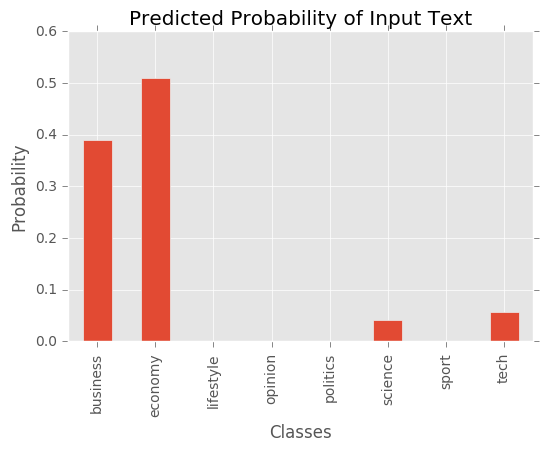

In [468]:

#print(lv.get_feature_names())
#print(cv.get_feature_names())


classes = pipeline.classes_
probability = pipeline.predict_proba(["SAP SE (Systemanalyse und Programmentwicklung; Systems, Applications & Products in Data Processing) is a German multinational software corporation that makes enterprise software to manage business operations and customer relations. Native of Germany, SAP is headquartered in Walldorf, Baden-Württemberg, with regional offices in 130 countries. The company has over 293,500 customers in 190 countries. The company is a component of the Euro Stoxx 50 stock market index."])
print_probabilites(probability, classes)

In [371]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

    
def print_probabilites(probability, classes):    
    matplotlib.style.use('ggplot')

    d = {'values': probability[0]}
    df = pd.DataFrame(d)


    ax = df.plot(kind='bar',legend=False,title='Predicted Probability of Input Text')
    ax.set_xticklabels(classes)
    ax.set_xlabel("Classes",fontsize=12)
    ax.set_ylabel("Probability",fontsize=12)

    plt.show()

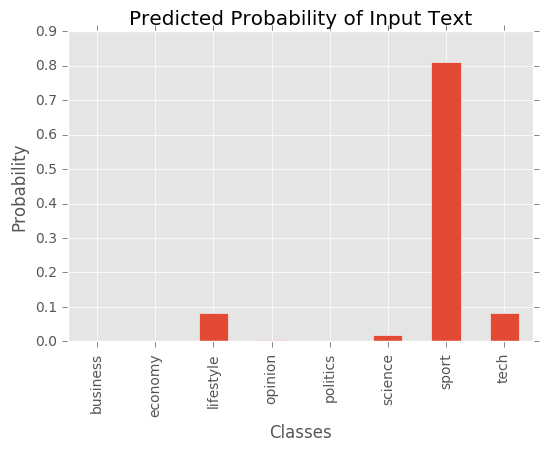

8


In [493]:
classes = pipeline.classes_
probability = pipeline.predict_proba(["Fußball-Club Bayern München e.V., commonly known as FC Bayern München, FCB, Bayern Munich, or FC Bayern, is a German sports club based in Munich, Bavaria, Germany. It is best known for its professional football team, which plays in the Bundesliga, the top tier of the German football league system, and is the most successful club in German football history, having won a record 26 national titles and 18 national cups."])
print_probabilites(probability, classes)

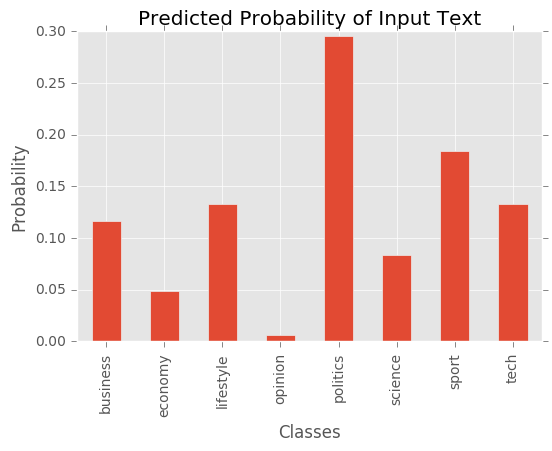

In [470]:
classes = pipeline.classes_
probability = pipeline.predict_proba(["Hillary is climate change to our society, but she likes football and bussiness."])
print_probabilites(probability, classes)

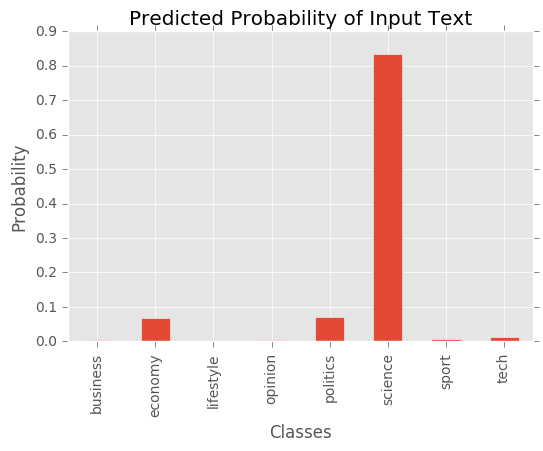

In [471]:
text = "Fake news is an epidemic on social media. Even President Barack Obama is concerned about the effect this reckless spread of misinformation is going to have on our nation, and, as he revealed in a lengthy interview with The New Yorker, the effect it will have on our planet. Obama blamed fake news — and social media more broadly — for being a major reason why the country can’t come together to combat global climate change. Obama spoke at length to The New Yorker’s editor David Remnick at length in the wake of Donald Trump’s stunning upset in the 2016 presidential election. Throughout the piece, Obama grapples with the implications of a Trump presidency and what it means for his own legacy. He also discussed his concerns about what fake news is doing to political discourse. Obama and his political director, David Simas, were “talking obsessively” about a recent BuzzFeed article that revealed that many sites propagating fake news were actually created by Macedonian teens."
classes = pipeline.classes_
probability = pipeline.predict_proba([text])
print_probabilites(probability, classes)
#print(pipeline.decision_function([text]))

In [502]:
print(clf.feature_log_prob_[0])

[-6.20371984 -6.35934394 -7.26497904 ..., -7.68501885 -4.35435309
 -7.68501885]


In [497]:
print(clf.coef_)
print(clf.intercept_)

[[-6.20371984 -6.35934394 -7.26497904 ..., -7.68501885 -4.35435309
  -7.68501885]
 [-7.08762365 -7.1789143  -6.61469916 ..., -7.5384208  -4.49503896
  -7.5384208 ]
 [-7.19741032 -7.28348847 -6.83531485 ..., -7.50444572 -4.3696948
  -7.50444572]
 ..., 
 [-6.60112889 -7.50764528 -7.50764528 ..., -7.50764528 -4.41741605
  -7.50764528]
 [-5.91872322 -7.34023741 -7.4350908  ..., -7.4350908  -4.34507651
  -7.4350908 ]
 [-6.76855669 -7.52675926 -6.72763432 ..., -7.52675926 -4.35021447
  -7.52675926]]
[-1.86894911 -2.1690537  -2.07374352 -2.7668907  -1.76358859 -2.12026354
 -2.12026354 -2.02929176]


In [498]:
print(clf.feature_count_)

[[  3.39865588   2.76472537   0.52202214 ...,   0.          26.95694822
    0.        ]
 [  0.56956286   0.43262224   1.51864646 ...,   0.          19.97606121
    0.        ]
 [  0.35938908   0.24727011   0.95253957 ...,   0.          21.98291052
    0.        ]
 ..., 
 [  1.47568316   0.           0.         ...,   0.          20.98211631
    0.        ]
 [  3.55564708   0.09949764   0.         ...,   0.          20.97739202
    0.        ]
 [  1.13443629   0.           1.2235943  ...,   0.          22.9638104    0.        ]]


In [499]:
len(clf.feature_count_)

8